# Tutorial 1: Analysis of osmFISH MSC data

The following tutorials demonstrates how to use PAST to obtain latent embeddings and decipher spatial domains on osmFISH Mouse Somatosensory Cortex (MSC) dataset([Codeluppi, et al., 2018](http://www.nature.com/articles/s41592-018-0175-z)).

## Prepration and data import

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

You can uncomment and execute the following command to download the osmFISH MSC dataset in AnnData format.

In [3]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/osmFISH_MSC.h5ad

In [4]:
## osmFISH MSC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
osmFISH_MSC = sc.read_h5ad(filename="osmFISH_MSC.h5ad")
osmFISH_MSC

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterID', 'ClusterName', 'Region', 'Valid'
    var: 'Fluorophore', 'Hybridization'
    obsm: 'spatial'

## Data Preprocessing

We set a random seed for all random process for reproducibility first.

In [5]:
past.setup_seed(666)
sdata = osmFISH_MSC.copy()

We filter out genes expressed in less than three spots and follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix. Since the gene number of STARmap MPVC dataset is less than 3000, there is no need to proceed with the step of gene selection.

In [6]:
sdata = past.preprocess(sdata, min_cells=3, is_filter_MT=True)

## Running PAST

We initialization of PAST model with latent dimension `d_lat=30` so that the latent dimension is smaller than the gene number of osmFISH MSC dataset.

In [7]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=30, k_neighbors=6, dropout=0.1).to(device)

We train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target osmFISH MSC anndata as self-prior marix.

In [8]:
PAST_model.model_train(sdata, epochs=50, lr=1e-3, batchsize=6400, device=device)

This dataset is small enough to train without Ripplewalk_sampler
Epoch:10 Time:1.97s Loss: 9.834625
Epoch:20 Time:1.66s Loss: 5.817118
Epoch:30 Time:1.65s Loss: 4.291026
Epoch:40 Time:1.66s Loss: 3.551848
Epoch:50 Time:1.74s Loss: 3.073708
Epoch:60 Time:1.65s Loss: 2.718571
Epoch:70 Time:1.70s Loss: 2.472935
Epoch:80 Time:1.68s Loss: 2.252422
Epoch:90 Time:1.78s Loss: 2.055867
Epoch:100 Time:1.78s Loss: 1.876279
Epoch:110 Time:1.79s Loss: 1.709191
Epoch:120 Time:1.80s Loss: 1.579540
Epoch:130 Time:1.69s Loss: 1.438076
Epoch:140 Time:1.73s Loss: 1.339844
Epoch:150 Time:1.73s Loss: 1.226726
Epoch:160 Time:1.69s Loss: 1.135266
Epoch:170 Time:1.70s Loss: 1.045838
Epoch:180 Time:1.71s Loss: 0.971031
Epoch:190 Time:1.62s Loss: 0.908428
Epoch:200 Time:1.65s Loss: 0.862362
Epoch:210 Time:1.75s Loss: 0.830849
Epoch:220 Time:1.83s Loss: 0.810711
Epoch:230 Time:1.77s Loss: 0.796035
Epoch:240 Time:1.81s Loss: 0.784878
Model Converge


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [9]:
sdata = PAST_model.output(sdata)

## Clustering and evaluation

The clustering result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [10]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["Region"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [11]:
print("MCVA score:", end="\t\t")
print("%.3f"%np.average(past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["Region"])))
print("Mclust metrics:", end="\t\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "Region", "mclust")
print("Dlouvain metrics:", end="\t")
ari, ami, homo, nmi = past.cluster_metrics(sdata, "Region", "Dlouvain")

MCVA score:		0.860
Mclust metrics:		ARI: 0.573, AMI: 0.657, Homo: 0.681, NMI: 0.659
Dlouvain metrics:	ARI: 0.585, AMI: 0.589, Homo: 0.593, NMI: 0.591


## Visualization

Visualization of latent embeddings colored by annotation and PAST-derived clusters.

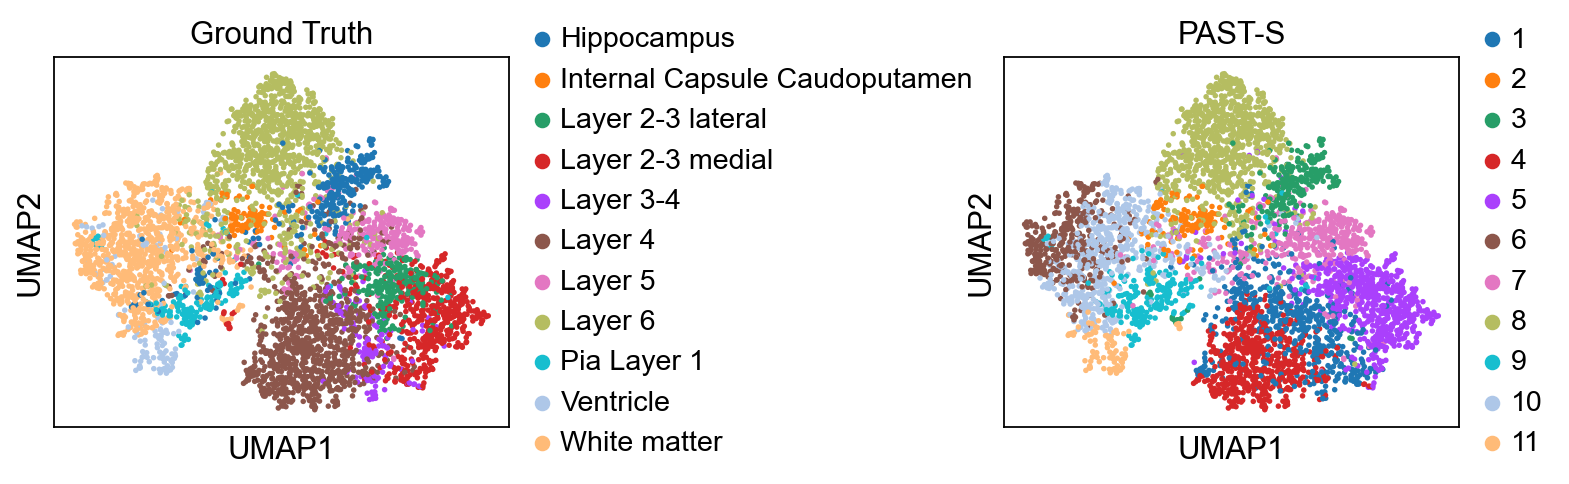

In [12]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["Region", "mclust"], title=["Ground Truth", "PAST-S"], wspace=0.9)

Visualization of spatial domains colored by annotation and PAST-derived clusters.

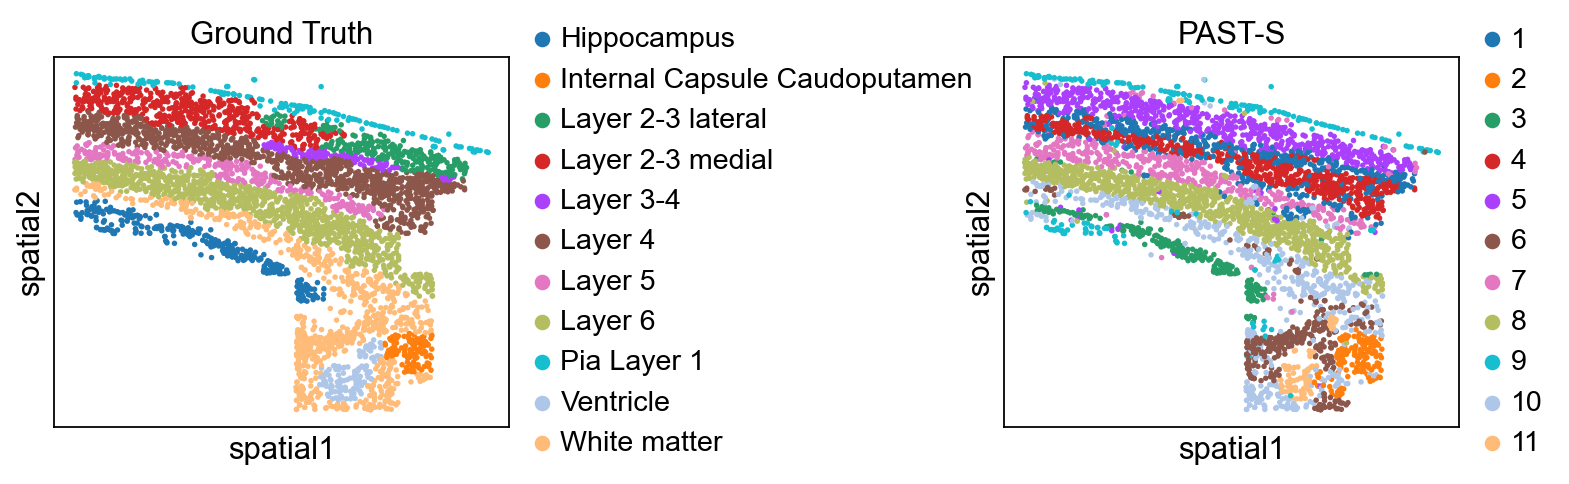

In [13]:
sc.pl.embedding(sdata, color=["Region", "mclust"], basis="spatial", title=["Ground Truth", "PAST-S"], wspace=0.9)